In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Matrix for computing forward model

We want to create a function that gets the depths of the geophones and the proposed layer structure of the subsurface to compute the **G** matrix defined as follows:

$$ \bf{d} = \bf{G} \bf{m} $$

where $\bf{d}$ is the travel times vector and $\bf{m}$ is the slowness vector of the layers.

In [2]:
def get_G_matrix(geophones_depth, n_layers, max_depth):
    """
    Compute matrix G for VSP forward model
    
    .. math ::
        d = Gm
    
    Where `d` is the travel times vector and `m` is the slowness vector,
    whose elements correspond to the slowness of each layer of the model.
    
    Parameter
    ---------
    geophones_depth : array
        Array of depths of the geophones
    n_layers : int
        Total number of layers of same thickness.
    max_depth : float
        Maximum depth of the layered model.
        The bottom of the last layer will be equal to this value.
        
    Returns
    -------
    G : numpy.matrix
        Matrix G that performs the VSP forward modelling
    """
    # Check if the layer structure is well defined
    if max_depth < max(geophones_depth):
        raise ValueError(
            "Layer structure must be as deep as the deepest geophone"
        )
    # Compute layer thickness
    layer_thickness = max_depth / n_layers
    # Initialize G matrix full of zeros
    n_geophones = len(geophones_depth)
    G = np.matrix(np.zeros((n_geophones, n_layers)))
    # Compute elements of G
    for i, depth in enumerate(geophones_depth):
        # Get the number of the layer where the geophone is located
        layer_of_geophone = int(depth // layer_thickness)
        G[i, :layer_of_geophone] = layer_thickness
        G[i, layer_of_geophone] = depth % layer_thickness
    return G

# Read data from `data_vsp.asc`

In [3]:
geophones_depth, travel_times = np.loadtxt("data_vsp.asc", unpack=True)

In [4]:
n_geophones = len(geophones_depth)

# Define inverse problem

We want to estimate the slowness structure that minimize the following cost function:

$$ J = || d - Gm ||^2 + \mu^2 || D (m - m_\text{ref}) ||^2 $$

where $||\cdot||^2$ notes the $L_2$ norm, $m_\text{ref}$ is the reference model of the subsurface, $D$ is the identity matrix and $\mu$ is the regularization paramter (a.k.a. trade-off parameter).

The model that minimizes this cost function can be obtained by solving the following linear problem:

$$ \left[ G^T W_e G + \mu^2 D^T D \right] m_\text{est} =  \left[ G^T W_e d + \mu^2 D^T D m_\text{ref} \right]$$

where $W_e$ is the diagonal matrix of data variances.

Lets define a function that performs this inversion of the time travel data.

In [5]:
def inverse_vsp(
    G_matrix,
    max_depth,
    reference_slowness,
    regularization_parameter,
    data_variance,
):
    """
    Compute slowness for the layered model of the subsurface
    
    Perform a linear deterministic inversion with a true value
    regularization and weighted factor in order to account for
    measurement errors.
    
    Parameters
    ----------
    G_matrix : numpy.matrix
        Forward model matrix that relates the slowness vector
        with the time travel vector
    max_depth : float
        Maximum depth of the layered model.
        The bottom of the last layer will be equal to this value.
    reference_slowness : float
        Value of the reference slowness on the subsurface.
        A penalization term is added for slownesses that deviates from
        the reference value.
    regularization_parameter : float
        Trade off parameter for the true value regularization.
    data_variance : float
        Variance of the measured time travels.
    """
    # Get number of geophones and number of layers
    n_geophones, n_layers = G.shape
    # Build reference model vector
    reference_model = 1/3 * np.ones(n_layers)
    # Build weights matrix and operator D
    W_e = data_variance * np.matrix(np.identity(n_geophones))
    D = np.matrix(np.identity(n_layers))
    A = (
        np.dot(G.T , np.dot(W_e, G))
        + regularization_parameter ** 2
        * np.dot(D.T, D)
    )
    B = (
        np.dot(G.T, np.dot(W_e, travel_times[:, np.newaxis]))
        + regularization_parameter ** 2
        * np.dot(D.T , np.dot(D, reference_model[:, np.newaxis]))
    )
    slowness = np.linalg.solve(A, B)
    return slowness

## Computation of the inverse problem

We must propose discretized model of the subsurface. We will asume N layers of equal thickess up to a maximum depth of 1km.

In [6]:
n_layers = 100
max_depth = 1

We will impose that our model should be close to a reference model of constant slowness of 1/3 s/km.

In [7]:
reference_slowness = 1 / 3

We must also set the variance of the data:

In [8]:
data_variance = 0.0018 ** 2

and the G matrix:

In [9]:
G = get_G_matrix(geophones_depth, n_layers, max_depth)

In [10]:
slowness = inverse_vsp(
    G,
    max_depth,
    reference_slowness,
    regularization_parameter=1e-10,
    data_variance=data_variance,
)

Lets perform several inversions, each one with a different value of the regularization parameter $\mu$:

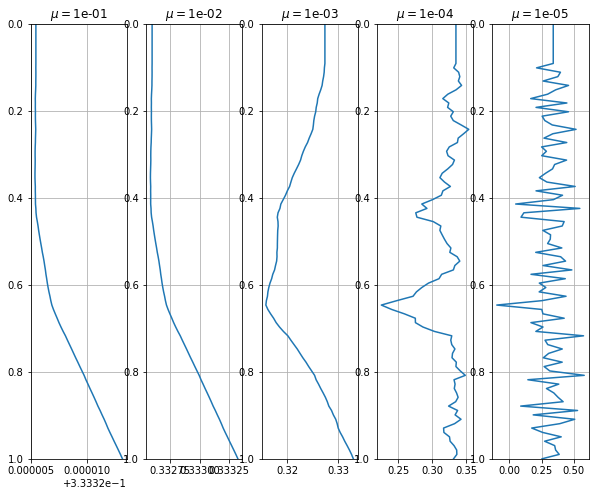

In [11]:
# Generate a list of regularization parameters
reg_params = np.logspace(-1, -5, 5)

# Define depths array
depths = np.linspace(0, max_depth, n_layers)

# Initialize figure
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(reg_params),
    figsize=(2 * len(reg_params), 8),
)

# Compute slowness for each reg parameter and plot
for mu, ax in zip(reg_params, axes):
    slowness = inverse_vsp(
        G,
        max_depth,
        reference_slowness,
        regularization_parameter=mu,
        data_variance=data_variance,
    )
    ax.plot(slowness, depths)
    ax.set_ylim(0, max_depth)
    ax.invert_yaxis()
    ax.grid()
    ax.set_title(r"$\mu=${:.0e}".format(mu))
plt.show()

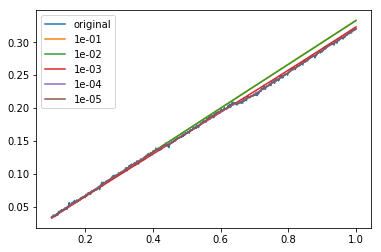

In [45]:
# Generate a list of regularization parameters
reg_params = np.logspace(-1, -5, 5)
#reg_params = [1e-3]

# Define depths array
depths = np.linspace(0, max_depth, n_layers)

# Initialize figure
fig, ax = plt.subplots()

ax.plot(geophones_depth, travel_times, label="original")

# Compute slowness for each reg parameter and plot
for mu in reg_params:
    slowness = inverse_vsp(
        G,
        max_depth,
        reference_slowness,
        regularization_parameter=mu,
        data_variance=data_variance,
    )
    ax.plot(geophones_depth, np.dot(G, slowness), label="{:.0e}".format(mu))
plt.legend()
plt.show()

# Chi square method

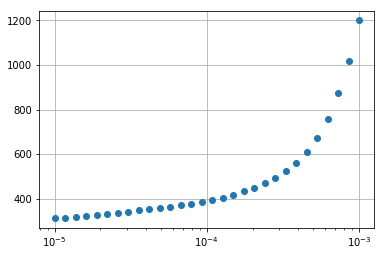

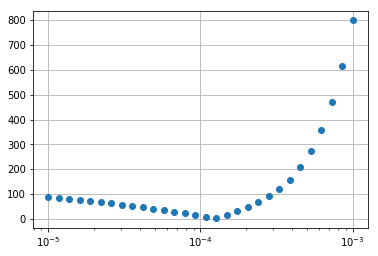

Optimal mu: 1.268961e-04


In [68]:
reg_params = np.logspace(-3, -5, 30)

chi_sq = []
for mu in reg_params:
    slowness = inverse_vsp(
        G,
        max_depth,
        reference_slowness,
        regularization_parameter=mu,
        data_variance=data_variance,
    )
    forward_times = np.array(np.dot(G, slowness)).ravel()
    misfit_sq = np.linalg.norm(travel_times - forward_times) ** 2
    chi_sq.append(misfit_sq / data_variance)
    
plt.plot(reg_params, chi_sq, 'o')
plt.xscale('log')
plt.grid()
plt.show()

plt.plot(reg_params, abs(np.array(chi_sq) - n_geophones), 'o')
plt.xscale('log')
plt.grid()
plt.show()

arg = np.argmin(abs(np.array(chi_sq) - n_geophones))
mu_chi_sq = reg_params[arg]
print("Optimal mu: {:e}".format(mu_chi_sq))

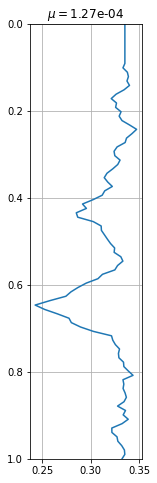

In [70]:
# Initialize figure
fig, ax = plt.subplots(figsize=(2, 8))

# Compute slowness for the optimal mu obtained through chi-sq

slowness = inverse_vsp(
    G,
    max_depth,
    reference_slowness,
    regularization_parameter=mu_chi_sq,
    data_variance=data_variance,
)
ax.plot(slowness, depths)
ax.set_ylim(0, max_depth)
ax.invert_yaxis()
ax.grid()
ax.set_title(r"$\mu=${:.2e}".format(mu_chi_sq))
plt.show()

# Trade-off Curve for different regularization parameters

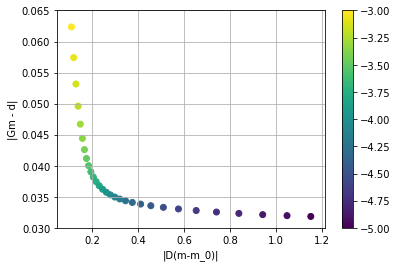

In [85]:
reg_params = np.logspace(-3, -5, 30)

misfit = []
true_value_norm = []
for mu in reg_params:
    slowness = inverse_vsp(
        G,
        max_depth,
        reference_slowness,
        regularization_parameter=mu,
        data_variance=data_variance,
    )
    forward_times = np.array(np.dot(G, slowness)).ravel()
    misfit.append(np.linalg.norm(travel_times - forward_times))
    D = np.matrix(np.identity(n_layers))
    true_value_norm.append(np.linalg.norm(np.dot(D, (slowness - reference_slowness))))
    
    
cm = plt.scatter(true_value_norm, misfit, c=np.log10(reg_params))
plt.grid()
plt.xlabel("|D(m-m_0)|")
plt.ylabel("|Gm - d|")
plt.ylim(0.03, 0.065)
plt.colorbar(cm)
plt.show()